In [38]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [39]:
from parking_position_detection_utils import ImageInfo
from parking_position_detection_utils import ImageProcessing

In [40]:
def load_tagged_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            route = os.path.join(directory, filename)
            images.append(ImageInfo(route))
    return images

In [41]:
# images_info = load_tagged_images('../manual_sequence/sec3/')
images_info = load_tagged_images('../parking_sequence')
images_info.sort(key=lambda x: x.time, reverse=False)

In [42]:
cv2.namedWindow("Images", cv2.WINDOW_NORMAL)
for i in range(1):  # Repeat 1 time
    for idx in range(len(images_info)):
        image = cv2.imread(images_info[idx].image_path, cv2.IMREAD_COLOR)
        cv2.imshow("Images", image)
        cv2.waitKey(100)
cv2.destroyAllWindows()

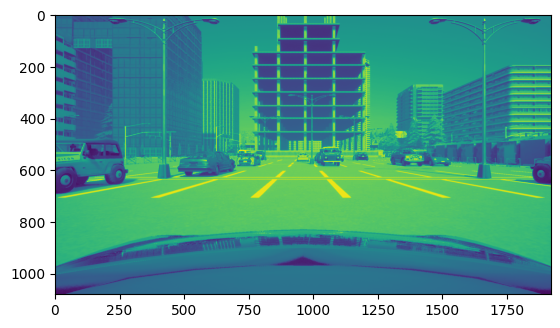

(1080, 1920)


In [43]:
image = cv2.imread(images_info[0].image_path, cv2.IMREAD_COLOR)
imageGray = cv2.imread(images_info[0].image_path, cv2.IMREAD_GRAYSCALE)
image_processing = ImageProcessing(imageGray)
plt.imshow(imageGray)
plt.show()
print(imageGray.shape)

# Below the horizon

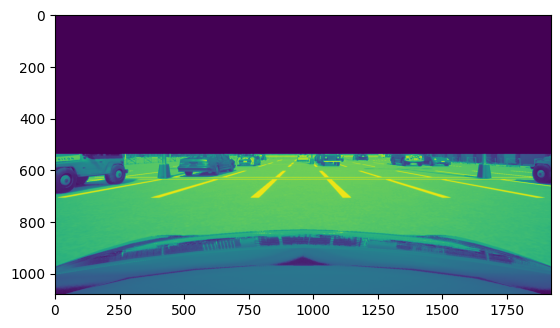

In [44]:
bottom_half = image_processing.cut_below_horizon(imageGray)
plt.imshow(bottom_half)
plt.show()

# Thresholded image

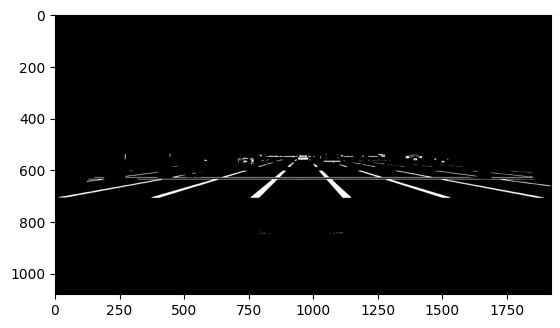

In [45]:
binary_gray_image = image_processing.treshold_image(bottom_half)
plt.imshow(binary_gray_image, cmap='gray')
plt.show()

# Canny contours

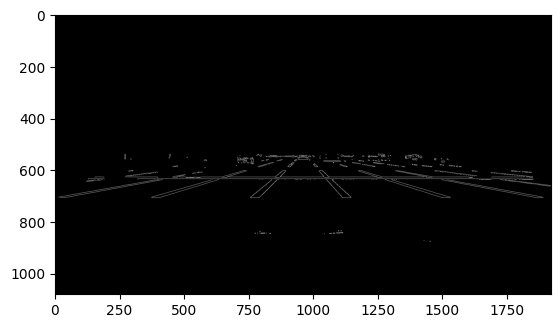

In [46]:
edges = image_processing.canny_coutours(binary_gray_image)
plt.imshow(edges, cmap="gray")
plt.show()

# Transformada de Hough

In [47]:
lines = image_processing.get_hough_lines(edges)

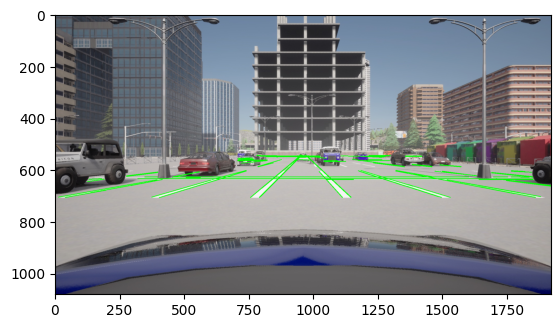

In [48]:

image_with_lines = np.copy(image)
if len(image_with_lines.shape) == 2:  # Si es una imagen en escala de grises
    image_with_lines = cv2.cvtColor(image_with_lines, cv2.COLOR_GRAY2BGR)  # Convertir a BGR para visualizar las líneas en color

# Dibujar las líneas detectadas en la imagen
lineEqs = np.zeros((len(lines), 3))
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Dibujar la línea en verde con grosor de 2

# Mostrar la imagen con las líneas detectadas
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para matplotlib
plt.show()

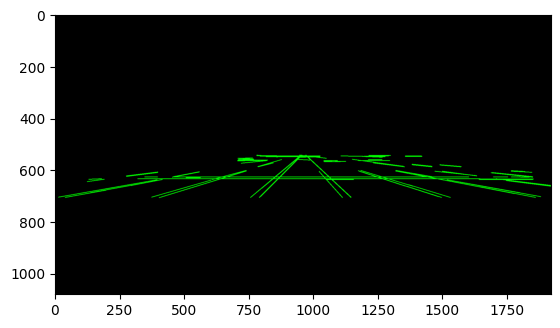

In [49]:
lines_only = np.zeros_like(image_with_lines)

# Dibujar las líneas detectadas en la imagen en negro
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(lines_only, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Dibujar la línea en verde con grosor de 2

# Mostrar la imagen con solo las líneas
plt.imshow(cv2.cvtColor(lines_only, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para matplotlib
plt.show()

# Calculamos el espacio nulo (a,b,c) de cada recta con SVD

ax+by+c=0

\begin{aligned}
\left[\begin{array}{ccc}
x_1 & y_1 & 1 \\
x_2 & y_2 & 1
\end{array}\right]
\begin{bmatrix}
a \\
b \\
c
\end{bmatrix}
=
\begin{bmatrix}
0 \\
0
\end{bmatrix}
\end{aligned}


In [50]:
lineEqs = image_processing.get_null_space_from_lines(lines)
print(lineEqs, lineEqs.shape)

[[-3.14180325e-19 -1.57480120e-03  9.99998760e-01]
 [ 1.71940037e-19 -1.59235467e-03  9.99998732e-01]
 [-2.48279389e-04 -1.41185742e-03  9.99998973e-01]
 [-3.58865692e-04 -1.22280162e-03  9.99999188e-01]
 [ 1.00502624e-19 -1.56739619e-03  9.99998772e-01]
 [ 5.47262117e-04 -2.84724210e-03  9.99995797e-01]
 [-3.67854224e-04 -1.20356188e-03  9.99999208e-01]
 [ 2.97441144e-04 -2.37952915e-03  9.99997125e-01]
 [ 3.35381847e-04 -2.47809920e-03  9.99996873e-01]
 [ 4.85704509e-04 -2.71474127e-03  9.99996197e-01]
 [ 2.83804829e-04 -2.33593206e-03  9.99997231e-01]
 [-3.52944662e-04 -1.22995867e-03  9.99999181e-01]
 [ 1.42570461e-03 -4.41968431e-03  9.99989217e-01]
 [ 1.98290515e-19 -1.81817881e-03  9.99998347e-01]
 [-6.68448899e-04 -6.68448899e-04  9.99999553e-01]
 [ 4.78476260e-04 -2.69860611e-03  9.99996244e-01]
 [-1.25361942e-18 -1.82815051e-03  9.99998329e-01]
 [ 2.65204382e-04 -2.29843798e-03  9.99997323e-01]
 [ 2.09447501e-19 -1.56739619e-03  9.99998772e-01]
 [ 2.34287439e-04 -2.28430253e-

calculamos la intersecion de cada recta con las demas

In [51]:
intersections, intLines, IntersectionsInf, intLineInf = image_processing.get_intersection(lines, lineEqs)


In [52]:
n_clusters=50
centroids, labels = image_processing.find_intersection_centroids(intersections, n_clusters)

In [53]:
def draw_centroids_in_image(centroids, intersections, labels, image):
    # Dibuja las intersecciones en color azul
    n = len(intersections)
    print("n=", n)
    print("labels.shape=", labels.shape)
    for idx in range(n):
        # print("labels[%d]=" % idx, labels[idx])
        point = intersections[idx]
        # print("point", point)
        cv2.circle(image, (int(point[0]), int(point[1])), radius=2, color=Paleta[labels[idx], :].tolist(), thickness=-1)

    # Dibuja los centroides en color rojo con una 'x'
    for point in centroids:
        cv2.drawMarker(image, (int(point[0]), int(point[1])), color=(255, 0, 255), markerType=cv2.MARKER_TILTED_CROSS,
                       markerSize=20, thickness=4)

    return image

def count_Clusters(n, labels):
    cont = np.zeros(n)
    for idx in range(n):
      cont[idx] = np.sum(labels == idx)
    return cont

In [54]:
Paleta = np.load("Paleta.npy")

n= 3307
labels.shape= (3307,)


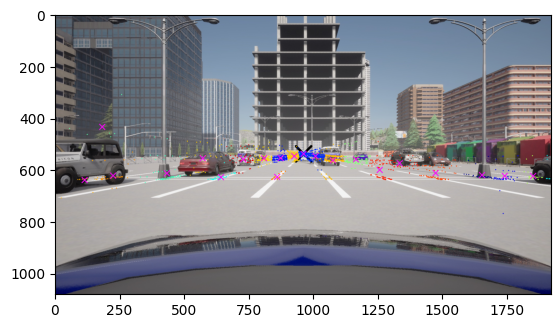

In [55]:
clustersSize = count_Clusters(len(centroids), labels)
idxMax = np.argmax(clustersSize)

cv2.drawMarker(image, (int(centroids[idxMax, 0]), int(centroids[idxMax][1])), color=(0, 0, 0),
                       markerType=cv2.MARKER_TILTED_CROSS, markerSize=60, thickness=8)

image_with_centroids = draw_centroids_in_image(centroids, intersections, labels, image.copy())
# cv2.imshow("Centroids", image_with_centroids)


# Mostrar la imagen con solo las líneas
plt.imshow(cv2.cvtColor(image_with_centroids, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para matplotlib
plt.show()